## **0. Mount the Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.chdir('/content/gdrive/My Drive/Deep Learning/CS410_Final')
!ls

 answer.txt  'Copy of answer.txt'   data   models   prob.txt   stopwords.txt


## Reference Tutorials:

Some of the codes below are from this tutorial with some customization for this project:
https://colab.research.google.com/drive/1ywsvwO6thOVOrfagjjfuxEf6xVRxbUNO#scrollTo=6J-FYdx6nFE_

In [ ]:
!pip install pytorch-pretrained-bert pytorch-nlp

     |████████████████████████████████| 133kB 12.7MB/s 
     |████████████████████████████████| 92kB 8.7MB/s 
     |████████████████████████████████| 133kB 41.1MB/s 
     |████████████████████████████████| 7.0MB 47.7MB/s 
     |████████████████████████████████| 71kB 10.1MB/s 
ERROR: botocore 1.19.30 has requirement urllib3<1.27,>=1.25.4; python_version != "3.4", but you'll have urllib3 1.24.3 which is incompatible.


In [ ]:
import pandas as pd
import random
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import torch.optim as optim
import io
import matplotlib.pyplot as plt
% matplotlib inline

# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

## BERT Model

## Load Dataset

In [ ]:
documents_path= 'data/train.jsonl'
df = pd.read_json(documents_path,lines=True)
# create sample and label list
sentences = df.response.values
# add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values 
labels=np.where(labels=='SARCASM', 1, labels) 
labels=np.where(labels=='NOT_SARCASM', 0, labels) 

#Use this line for bert base model
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased', do_lower_case=True)
tokenized_texts2 = [tokenizer.tokenize(sent) for sent in sentences]

#Remove stopwords
stop_word = open("stopwords.txt", "r")
stop_word = stop_word.read().splitlines()    
stop_word.append('@')
stop_word.append('user')

tokenized_texts=[]
for sublist in tokenized_texts2: 
    ele=[]
    for word in sublist: 
        if not word in stop_word:
            ele.append(word)
    tokenized_texts.append(ele)

100%|██████████| 231508/231508 [00:00<00:00, 16662918.80B/s]


## Set up BERT Inputs

In [ ]:
# Set the maximum sequence length. 
def max_seq_len():
    maxl=0
    for i in range(5000):
        if len(tokenized_texts[i]) > maxl:
            maxl = len(tokenized_texts[i])
    print (maxl)

#The longest sequence in our training set is 74, but we'll leave some room so set up at 128
MAX_LEN = 128

# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

# Use train_test_split to split our data into train and validation sets for training
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=10, test_size=0.2)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids, random_state=10, test_size=0.2)
train_labels=train_labels.astype(float)
validation_labels=validation_labels.astype(float)

# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels,dtype=torch.long)
validation_labels = torch.tensor(validation_labels,dtype=torch.long)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

# Select a batch size for training.
batch_size = 16

# Create an iterator of our data with torch DataLoader. This helps save on memory during training
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

## Train Model

In [ ]:
#Use this line for bert base model
#model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model = BertForSequenceClassification.from_pretrained("bert-large-uncased", num_labels=2)
model.cuda()

100%|██████████| 1248501532/1248501532 [00:21<00:00, 57524814.78B/s]


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace

## Parameters

In [ ]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.001},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}]

In [ ]:
# Instead of using the default optimizer BertAdam, I use the Adam optimizer in the torch library with tuning parameters
# It turns out that it performs better than BertAdam 
#optimizer = BertAdam(optimizer_grouped_parameters, lr=2e-5, warmup=.1)
optimizer = optim.Adam(optimizer_grouped_parameters, lr=5e-6)

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    tp,fp,fn = 0,0,0
    for i in range(len(labels_flat)):
        if pred_flat[i] == 1 and labels_flat[i]==1:
            tp += 1
        elif pred_flat[i] == 1 and labels_flat[i]==0:
            fp += 1
        elif pred_flat[i] == 0 and labels_flat[i]==1:
            fn += 1  
    return tp,fp,fn

In [ ]:
# Number of training epochs (authors recommend between 2 and 4)
epochs = 50
t = [] 
train_loss_set = []

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  # Training
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
 
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
  
  #Save the model so we don't need to retrain the model every time
  #Save the model
  PATH="models/BERT_Best_2020Nov8"
  torch.save(model.state_dict(), PATH)
    
  # Validation
  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0
  eval_tp, eval_fp, eval_fn = 0, 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tp,fp,fn = flat_accuracy(logits, label_ids)
    
    #eval_accuracy += tmp_eval_accuracy
    #nb_eval_steps += 1

    eval_tp += tp
    eval_fp += fp
    eval_fn += fn
 
    precision,recall,f1 = 0,0,0
    precision = eval_tp / (eval_tp + eval_fp + 0.01)
    recall = eval_tp / (eval_tp + eval_fn + 0.01)
    F1 = 2*precision*recall / (precision + recall + 0.01)

  print("Validation F1 Score: {}".format(F1))
  print("Validation Precision Score: {}".format(precision))
  print("Validation Recall Score: {}".format(recall))

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Train loss: 0.5876763174533844


Epoch:   2%|▏         | 1/50 [06:28<5:16:56, 388.09s/it]

Validation F1 Score: 0.7676154146052888
Validation Precision Score: 0.7133214446425893
Validation Recall Score: 0.8425031003326706
Train loss: 0.4934219738841057


Epoch:   4%|▍         | 2/50 [12:36<5:05:42, 382.13s/it]

Validation F1 Score: 0.7572917437925312
Validation Precision Score: 0.7457486676333779
Validation Recall Score: 0.7795122143264896
Train loss: 0.43972327530384064


Epoch:   6%|▌         | 3/50 [18:44<4:56:04, 377.96s/it]

Validation F1 Score: 0.7908923918181269
Validation Precision Score: 0.7147223397752387
Validation Recall Score: 0.897620125588079
Train loss: 0.36706029322743416


Epoch:   8%|▊         | 4/50 [24:52<4:47:31, 375.04s/it]

Validation F1 Score: 0.7838869870770107
Validation Precision Score: 0.7696485084548979
Validation Recall Score: 0.809039192141887
Train loss: 0.29103702755272387


Epoch:  10%|█         | 5/50 [31:01<4:39:48, 373.08s/it]

Validation F1 Score: 0.7950264862763408
Validation Precision Score: 0.7647977594657187
Validation Recall Score: 0.8385661699572843
Train loss: 0.22231739746034146


Epoch:  12%|█▏        | 6/50 [37:09<4:32:32, 371.66s/it]

Validation F1 Score: 0.7890751439492195
Validation Precision Score: 0.7987888687476346
Validation Recall Score: 0.7893545402649554
Train loss: 0.15829105029255153


Epoch:  14%|█▍        | 7/50 [43:18<4:25:41, 370.72s/it]

Validation F1 Score: 0.7985016991526213
Validation Precision Score: 0.7904611340736367
Validation Recall Score: 0.8169130528926596
Train loss: 0.10934291379898786


Epoch:  16%|█▌        | 8/50 [49:26<4:19:00, 370.02s/it]

Validation F1 Score: 0.7890166740320981
Validation Precision Score: 0.8068941688177069
Validation Recall Score: 0.7814806795141828
Train loss: 0.07651696697901934


Epoch:  18%|█▊        | 9/50 [55:35<4:12:38, 369.71s/it]

Validation F1 Score: 0.8154950175366841
Validation Precision Score: 0.7777640605985785
Validation Recall Score: 0.8680931477726817
Train loss: 0.061865175793878735


Epoch:  20%|██        | 10/50 [1:01:44<4:06:14, 369.36s/it]

Validation F1 Score: 0.7765629450337569
Validation Precision Score: 0.8158283548532151
Validation Recall Score: 0.7499852365110923
Train loss: 0.048712983450852336


Epoch:  22%|██▏       | 11/50 [1:07:52<3:59:56, 369.14s/it]

Validation F1 Score: 0.7806652606299842
Validation Precision Score: 0.8201109183957517
Validation Recall Score: 0.7539221668864786
Train loss: 0.048557110268156976


Epoch:  24%|██▍       | 12/50 [1:14:01<3:53:41, 368.98s/it]

Validation F1 Score: 0.8059314824666085
Validation Precision Score: 0.8030732997432483
Validation Recall Score: 0.8188815180803528
Train loss: 0.030030351085821166


Epoch:  26%|██▌       | 13/50 [1:20:09<3:47:27, 368.86s/it]

Validation F1 Score: 0.7981803504311857
Validation Precision Score: 0.8071410111130991
Validation Recall Score: 0.7991968662034212
Train loss: 0.02977936734049581


Epoch:  28%|██▊       | 14/50 [1:26:18<3:41:15, 368.76s/it]

Validation F1 Score: 0.7874316690772712
Validation Precision Score: 0.8036274569340702
Validation Recall Score: 0.7814806795141828
Train loss: 0.02735841214703396


Epoch:  30%|███       | 15/50 [1:32:26<3:35:01, 368.62s/it]

Validation F1 Score: 0.8137192184758594
Validation Precision Score: 0.7793455632462056
Validation Recall Score: 0.8621877522096022
Train loss: 0.02516504549444653


Epoch:  32%|███▏      | 16/50 [1:38:35<3:28:55, 368.68s/it]

Validation F1 Score: 0.7950157279876172
Validation Precision Score: 0.808836844329088
Validation Recall Score: 0.7913230054526486
Train loss: 0.028895493095740677


Epoch:  34%|███▍      | 17/50 [1:44:45<3:23:01, 369.14s/it]

Validation F1 Score: 0.766194729112741
Validation Precision Score: 0.8218079775506114
Validation Recall Score: 0.7263636542587745
Train loss: 0.014778021763195284


Epoch:  36%|███▌      | 18/50 [1:50:54<3:16:48, 369.02s/it]

Validation F1 Score: 0.8039394450288937
Validation Precision Score: 0.7973078908625074
Validation Recall Score: 0.8208499832680459
Train loss: 0.01639224299835041


Epoch:  38%|███▊      | 19/50 [1:57:02<3:10:34, 368.86s/it]

Validation F1 Score: 0.7877389084797559
Validation Precision Score: 0.8149518721024511
Validation Recall Score: 0.771638353575717
Train loss: 0.017980043251707684


Epoch:  40%|████      | 20/50 [2:03:11<3:04:25, 368.86s/it]

Validation F1 Score: 0.7474675042581179
Validation Precision Score: 0.8258629208724501
Validation Recall Score: 0.6909312808802976
Train loss: 0.02629626293241745


Epoch:  42%|████▏     | 21/50 [2:09:20<2:58:16, 368.86s/it]

Validation F1 Score: 0.8009556384383746
Validation Precision Score: 0.8107408218959782
Validation Recall Score: 0.8011653313911143
Train loss: 0.013000565610913327


Epoch:  44%|████▍     | 22/50 [2:15:30<2:52:14, 369.09s/it]

Validation F1 Score: 0.7867787344352059
Validation Precision Score: 0.8311508408908899
Validation Recall Score: 0.7558906320741717
Train loss: 0.014684231530758552


Epoch:  46%|████▌     | 23/50 [2:21:39<2:46:10, 369.26s/it]

Validation F1 Score: 0.8156826016068726
Validation Precision Score: 0.7845460584190589
Validation Recall Score: 0.8602192870219091
Train loss: 0.010048861105431569


Epoch:  48%|████▊     | 24/50 [2:27:49<2:40:01, 369.30s/it]

Validation F1 Score: 0.817584217461741
Validation Precision Score: 0.7752478179822652
Validation Recall Score: 0.8759670085234543
Train loss: 0.011505542488215724


Epoch:  50%|█████     | 25/50 [2:33:58<2:33:54, 369.38s/it]

Validation F1 Score: 0.7966027038250636
Validation Precision Score: 0.8079838403231936
Validation Recall Score: 0.7952599358280349
Train loss: 0.01165980835193477


Epoch:  52%|█████▏    | 26/50 [2:40:08<2:27:49, 369.57s/it]

Validation F1 Score: 0.7993206057327951
Validation Precision Score: 0.7995953386120893
Validation Recall Score: 0.809039192141887
Train loss: 0.017487711220484925


Epoch:  54%|█████▍    | 27/50 [2:46:18<2:21:40, 369.58s/it]

Validation F1 Score: 0.7840125121652829
Validation Precision Score: 0.8181645208346546
Validation Recall Score: 0.7617960276372513
Train loss: 0.0055440847617865075


Epoch:  56%|█████▌    | 28/50 [2:52:28<2:15:31, 369.63s/it]

Validation F1 Score: 0.7857167842137712
Validation Precision Score: 0.8128729132450468
Validation Recall Score: 0.7696698883880239
Train loss: 0.013788968366920017


Epoch:  58%|█████▊    | 29/50 [2:58:38<2:09:28, 369.92s/it]

Validation F1 Score: 0.7913889994883168
Validation Precision Score: 0.8160988409330386
Validation Recall Score: 0.7775437491387965
Train loss: 0.015440815810259665


Epoch:  60%|██████    | 30/50 [3:04:48<2:03:17, 369.85s/it]

Validation F1 Score: 0.7861386599399792
Validation Precision Score: 0.8115774000538292
Validation Recall Score: 0.771638353575717
Train loss: 0.01017964690394001


Epoch:  62%|██████▏   | 31/50 [3:10:58<1:57:05, 369.77s/it]

Validation F1 Score: 0.8033152379634737
Validation Precision Score: 0.8114918354794548
Validation Recall Score: 0.8051022617665007
Train loss: 0.014173782623416628


Epoch:  64%|██████▍   | 32/50 [3:17:07<1:50:54, 369.68s/it]

Validation F1 Score: 0.8052914089798304
Validation Precision Score: 0.813475923096764
Validation Recall Score: 0.8070707269541938
Train loss: 0.00639172316143231


Epoch:  66%|██████▌   | 33/50 [3:23:16<1:44:41, 369.52s/it]

Validation F1 Score: 0.789372989696823
Validation Precision Score: 0.8140327679180183
Validation Recall Score: 0.7755752839511033
Train loss: 0.012820464978780364


Epoch:  68%|██████▊   | 34/50 [3:29:25<1:38:28, 369.25s/it]

Validation F1 Score: 0.7726914085825743
Validation Precision Score: 0.8191542667915732
Validation Recall Score: 0.7401429105726265
Train loss: 0.00963111943997501


Epoch:  70%|███████   | 35/50 [3:35:34<1:32:17, 369.19s/it]

Validation F1 Score: 0.8137192184758594
Validation Precision Score: 0.7793455632462056
Validation Recall Score: 0.8621877522096022
Train loss: 0.011173322410570109


Epoch:  72%|███████▏  | 36/50 [3:41:43<1:26:06, 369.05s/it]

Validation F1 Score: 0.8131978602735148
Validation Precision Score: 0.8041672211554913
Validation Recall Score: 0.8326607743942048
Train loss: 0.003605348839351791


Epoch:  74%|███████▍  | 37/50 [3:47:51<1:19:55, 368.90s/it]

Validation F1 Score: 0.8093864788768705
Validation Precision Score: 0.8258942126677598
Validation Recall Score: 0.8031337965788076
Train loss: 0.0037206539220860577


Epoch:  76%|███████▌  | 38/50 [3:54:00<1:13:47, 368.92s/it]

Validation F1 Score: 0.8096884290044543
Validation Precision Score: 0.7992272873619818
Validation Recall Score: 0.8306923092065117
Train loss: 0.008655681198149977


Epoch:  78%|███████▊  | 39/50 [4:00:09<1:07:36, 368.76s/it]

Validation F1 Score: 0.8075150142451267
Validation Precision Score: 0.8061859266293289
Validation Recall Score: 0.8188815180803528
Train loss: 0.009301619400139316


Epoch:  80%|████████  | 40/50 [4:06:17<1:01:27, 368.76s/it]

Validation F1 Score: 0.7437116753017633
Validation Precision Score: 0.8369626043161967
Validation Recall Score: 0.6771520245664455
Train loss: 0.014453783535849652


Epoch:  82%|████████▏ | 41/50 [4:12:26<55:19, 368.83s/it]  

Validation F1 Score: 0.7608644551475591
Validation Precision Score: 0.8249812504261267
Validation Recall Score: 0.7145528631326156
Train loss: 0.004195711722539272


Epoch:  84%|████████▍ | 42/50 [4:18:35<49:09, 368.73s/it]

Validation F1 Score: 0.8035272282831154
Validation Precision Score: 0.7946616984467976
Validation Recall Score: 0.822818448455739
Train loss: 0.007016771192469605


Epoch:  86%|████████▌ | 43/50 [4:24:43<43:00, 368.70s/it]

Validation F1 Score: 0.8064095933937101
Validation Precision Score: 0.8097880433716986
Validation Recall Score: 0.8129761225172732
Train loss: 0.005585929510867572


Epoch:  88%|████████▊ | 44/50 [4:30:52<36:51, 368.64s/it]

Validation F1 Score: 0.8103296815883038
Validation Precision Score: 0.7932813169214726
Validation Recall Score: 0.8385661699572843
Train loss: 0.006265895185242698


Epoch:  90%|█████████ | 45/50 [4:37:01<30:43, 368.75s/it]

Validation F1 Score: 0.826682391817365
Validation Precision Score: 0.7806428213675066
Validation Recall Score: 0.8897462648373063
Train loss: 0.0013423664586152881


Epoch:  92%|█████████▏| 46/50 [4:43:10<24:34, 368.73s/it]

Validation F1 Score: 0.8142479774079204
Validation Precision Score: 0.800736828255108
Validation Recall Score: 0.8385661699572843
Train loss: 0.008718710718705551


Epoch:  94%|█████████▍| 47/50 [4:49:18<18:26, 368.69s/it]

Validation F1 Score: 0.7958221609389537
Validation Precision Score: 0.8189131910866032
Validation Recall Score: 0.783449144701876
Train loss: 0.004572732045562589


Epoch:  96%|█████████▌| 48/50 [4:55:27<12:17, 368.64s/it]

Validation F1 Score: 0.788541478314779
Validation Precision Score: 0.8166496531322265
Validation Recall Score: 0.771638353575717
Train loss: 0.010786418569172384


Epoch:  98%|█████████▊| 49/50 [5:01:36<06:08, 368.72s/it]

Validation F1 Score: 0.7989559558171727
Validation Precision Score: 0.8047178556635964
Validation Recall Score: 0.8031337965788076
Train loss: 0.004661065662927285


Epoch: 100%|██████████| 50/50 [5:07:44<00:00, 369.29s/it]

Validation F1 Score: 0.7688271247013221
Validation Precision Score: 0.8355973607908496
Validation Recall Score: 0.720458258695695


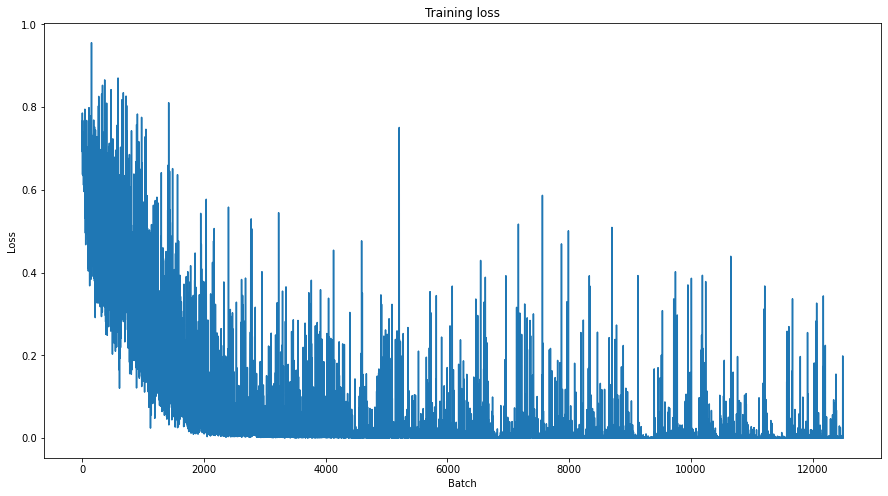

In [ ]:
#Evaluation
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

## Load Model

In [ ]:
#Load model
model = BertForSequenceClassification.from_pretrained("bert-large-uncased", num_labels=2)
PATH="models/BERT_Best_2020Nov8"
model.load_state_dict(torch.load(PATH))
model.cuda()


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace

## Predict

In [ ]:
test_document_path = 'data/test.jsonl'
MAX_LEN = 128
batch_size=16
def prediction_prep(test_document_path):
    df = pd.read_json(test_document_path, lines=True)
    sentences = df.response.values
    sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
    tokenizer = BertTokenizer.from_pretrained('bert-large-uncased', do_lower_case=True)
    tokenized_texts2 = [tokenizer.tokenize(sent) for sent in sentences]
    stop_word = open("stopwords.txt", "r")
    stop_word = stop_word.read().splitlines()    
    stop_word.append('@')
    stop_word.append('user')
    tokenized_texts=[]
    for sublist in tokenized_texts2: 
        ele=[]
        for word in sublist: 
            if not word in stop_word:
                ele.append(word)
        tokenized_texts.append(ele)

    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
    attention_masks = []
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask) 

    prediction_inputs = torch.tensor(input_ids)
    prediction_masks = torch.tensor(attention_masks)
    prediction_data = TensorDataset(prediction_inputs, prediction_masks)
    prediction_sampler = SequentialSampler(prediction_data)
    prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

    # Predict 
    model.eval()
    predictions=[]

    for batch in prediction_dataloader:
      # Add batch to GPU
      batch = tuple(t.to(device) for t in batch)
      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask = batch
      # Telling the model not to compute or store gradients, saving memory and speeding up prediction
      with torch.no_grad():
        # Forward pass, calculate logit predictions
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

      # Move logits and labels to CPU
      logits = logits.detach().cpu().numpy()

      # Store predictions and true labels
      predictions.append(logits)
    return predictions

In [ ]:
def generate_output(predictions):
    res=[]; odd=[]
    for pred in predictions:
       odd.append(pred[:,0].flatten()) 
    odd=np.concatenate(odd).ravel()
    #convert logit to probability
    odd=np.exp(odd)
    prob=odd/(1+odd)
    
    #Set threshold
    thresh = 0.8
    for i in range(len(prob)):
        if prob[i] > thresh:
            res.append('NOT_SARCASM')
        else:
            res.append('SARCASM')

    twitter_id=[]
    for i in range(1800):
        twitter_id.append('twitter_' + str(i+1))

    results = zip(twitter_id,res)
    res2=[]
    for i ,j in results:
        res2.append(str(i)+','+str(j))
 
    with open('answer.txt', 'w') as filehandle:
        filehandle.writelines("%s\n" % place for place in res2)

    with open('prob.txt', 'w') as filehandle:
        filehandle.writelines("%s\n" % place for place in prob)
 
predictions=prediction_prep(test_document_path)
generate_output(predictions)

